Some code to test the DMP with analytical solution and numerical solution

In [14]:
# add parent directory to path
import sys
sys.path.append('../')
from utils.data_loader import DataLoader
from models.dmp import CanonicalSystem, SingleDMP, TrainSingleDMP, TrainDMPs
import matplotlib.pyplot as plt

Load data

In [50]:
# load the data
cs = CanonicalSystem(dt=0.01, ax=1)
dmp = SingleDMP(n_bfs=50, cs=cs, run_time=1.0, dt=0.01)
traj_loader = DataLoader(dmp=dmp, run_time=1, dt=0.01, dof=2)
traj_loader.load_data_all("../data/number_write")
path, _ = traj_loader.paths[3]
path -= path[0, :]
x_path = path[:, 0]
y_path = path[:, 1]

test the analytical solution of single DMP

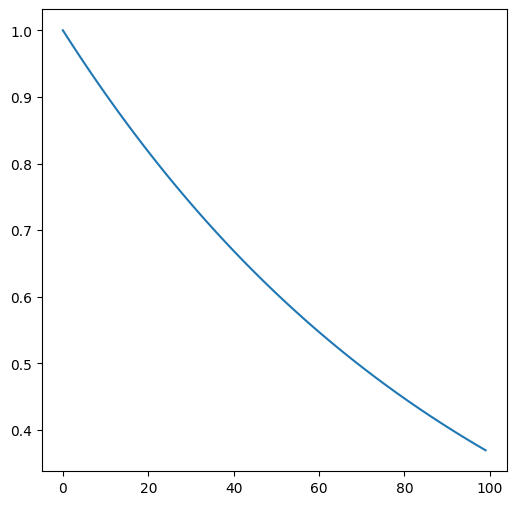

In [51]:
cs = CanonicalSystem(dt=0.01, run_time=1, ax=1)
x = cs.rollout(error_coupling=1)
plt.figure(1, figsize=(6, 6))
plt.plot(x.numpy())

In [52]:
dmp1 = SingleDMP(n_bfs=20, run_time=1, cs=cs, device='cpu')
dmp2 = SingleDMP(n_bfs=20, run_time=1, cs=cs, device='cpu')
dmp1.imitate_path(x_path)
dmp2.imitate_path(y_path)

In [53]:
import torch
x_target_force = dmp1.gen_target_force(torch.from_numpy(x_path))
y_target_force = dmp2.gen_target_force(torch.from_numpy(y_path))
x_gen_force = dmp1.gen_force()
y_gen_force = dmp2.gen_force()

Plot the basis function

Text(0.5, 1.0, 'DMP system - basis function')

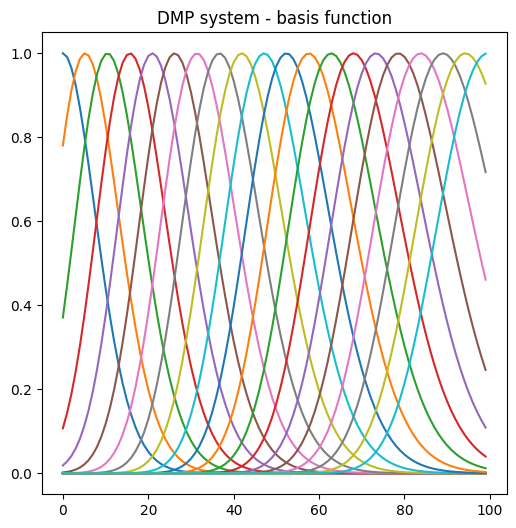

In [54]:
x_c = cs.rollout()
basic = dmp1.gen_psi(x_c)
plt.figure(1, figsize=(6, 6))
plt.plot(basic.numpy())
plt.title("DMP system - basis function")

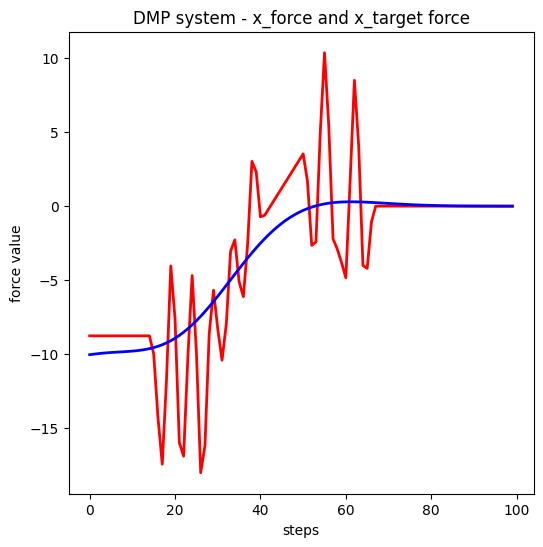

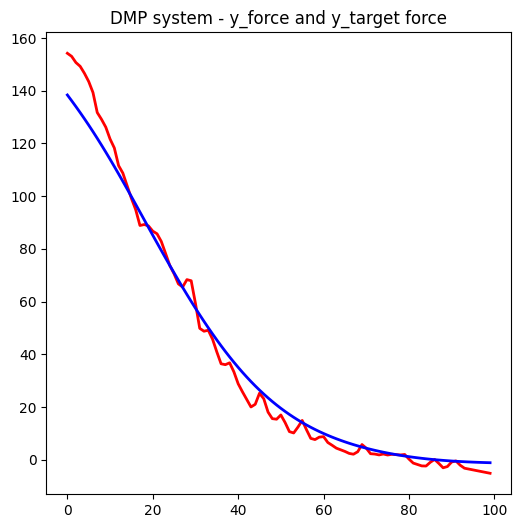

In [55]:
plt.figure(1, figsize=(6, 6))
plt.plot(x_target_force.numpy(), "r", lw=2)
plt.plot(x_gen_force.numpy(), "b", lw=2)
plt.title("DMP system - x_force and x_target force")
plt.xlabel('steps')
plt.ylabel('force value')
plt.show()

plt.figure(1, figsize=(6, 6))
plt.plot(y_target_force.numpy(), "r", lw=2)
plt.plot(y_gen_force.numpy(), "b", lw=2)
plt.title("DMP system - y_force and y_target force")
plt.show()

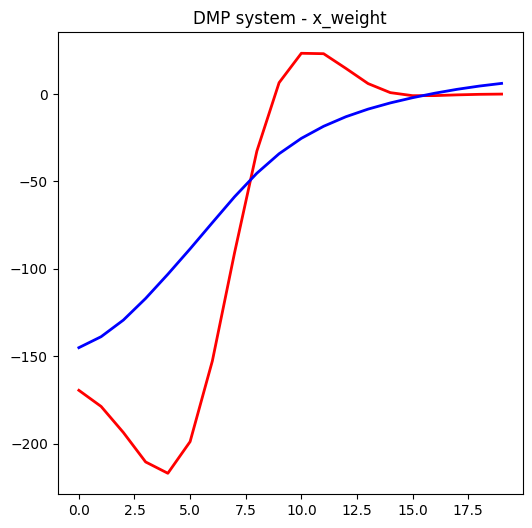

In [56]:
plt.figure(1, figsize=(6, 6))
plt.plot(dmp1.w.numpy(), "r", lw=2)
plt.plot(dmp2.w.numpy(), "b", lw=2)
plt.title("DMP system - x_weight")
plt.show()

In [57]:
# rollout the DMP to check the results
new_goal_x = x_path[-1] + 0.5
new_goal_y = y_path[-1] - 0.5

x1, _, _ = dmp1.rollout(y0=x_path[0], goal=x_path[-1])
# print the length of the trajectory
print(len(x1))
y1, _, _ = dmp2.rollout(y0=y_path[0], goal=y_path[-1])

100


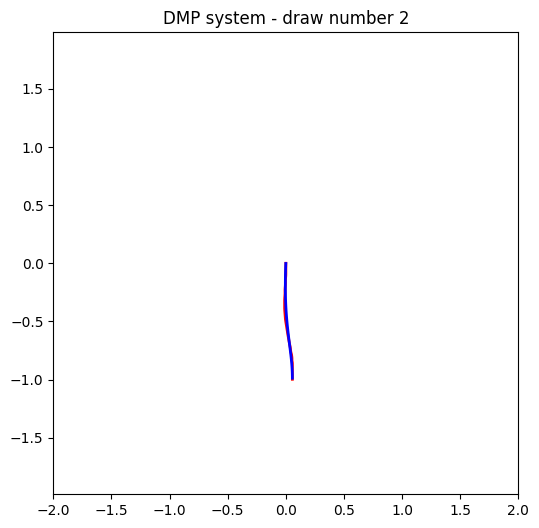

In [58]:
plt.figure(1, figsize=(6, 6))
plt.plot(x_path, y_path, "r", lw=2)
plt.plot(x1, y1, "b", lw=2)
plt.title("DMP system - draw number 2")

plt.axis("equal")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()

# scaling ability of dmp comes from scaling the force term

Text(0.5, 1.0, 'DMP system - draw number 2 with force')

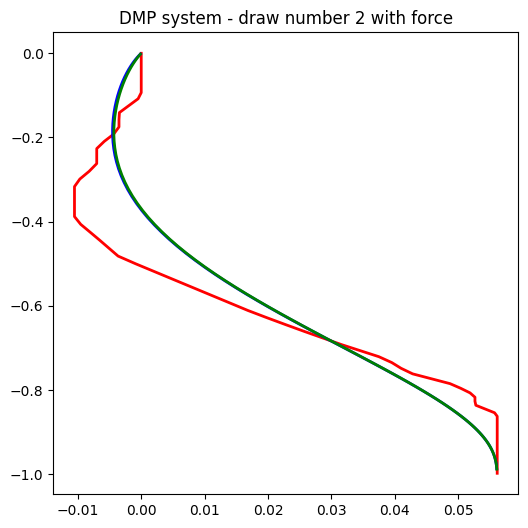

In [59]:
# sacle the force 
x_scale = (new_goal_x - x_path[0]) / (x_path[-1] - x_path[0])
y_scale = (new_goal_y - y_path[0]) / (y_path[-1] - y_path[0])
new_gen_force_x = x_gen_force * x_scale * 0.5
new_gen_force_y = y_gen_force * y_scale * 0.5

# rollout the DMP to check the results
new_x, _, _ =dmp1.torque_rollout(y0=x_path[0], goal=x_path[-1], f=x_gen_force)
new_y, _, _ = dmp2.torque_rollout(y0=y_path[0], goal=y_path[-1], f=y_gen_force)

# plot and compare with x1, y1
plt.figure(1, figsize=(6, 6))
plt.plot(x_path, y_path, "r", lw=2)
plt.plot(new_x, new_y, "b", lw=2)
plt.plot(x1, y1, "g", lw=2)
plt.title("DMP system - draw number 2 with force")

In [49]:
x_dmp_train = TrainSingleDMP(n_bfs=20, cs=cs, device='cpu')
optimizer1 = torch.optim.SGD(x_dmp_train.parameters(), lr=0.1)
x_dmp_train.train_dmp(optimizer=optimizer1, path=x_path, epoch=2000)

y_dmp_train = TrainSingleDMP(n_bfs=20, cs=cs, device='cpu')
optimizer2 = torch.optim.SGD(y_dmp_train.parameters(), lr=0.1)
y_dmp_train.train_dmp(optimizer=optimizer2, path=y_path, epoch=5000)

epoch: 199, loss: 41.564944177630416
epoch: 399, loss: 41.443231308495434
epoch: 599, loss: 41.32216773146195
epoch: 799, loss: 41.20174830189754
epoch: 999, loss: 41.081968099291316
epoch: 1199, loss: 40.96282210360499
epoch: 1399, loss: 40.84430525218243
epoch: 1599, loss: 40.72641263659498
epoch: 1799, loss: 40.60913943317585
epoch: 1999, loss: 40.492481151537234
epoch: 199, loss: 132.37558704718202
epoch: 399, loss: 79.42539546814979
epoch: 599, loss: 71.89899890593708
epoch: 799, loss: 67.10590549676188
epoch: 999, loss: 63.76979209688796
epoch: 1199, loss: 61.30896955632592
epoch: 1399, loss: 59.41613741404939
epoch: 1599, loss: 57.91347799273493
epoch: 1799, loss: 56.69091785749053
epoch: 1999, loss: 55.676755949189904
epoch: 2199, loss: 54.82220785246194
epoch: 2399, loss: 54.09310067081964
epoch: 2599, loss: 53.46468357236863
epoch: 2799, loss: 52.918680250378145
epoch: 2999, loss: 52.44120084331591
epoch: 3199, loss: 52.02155666868585
epoch: 3399, loss: 51.65129723685969
epoc

KeyboardInterrupt: 

In [ ]:
for name, param in x_dmp_train.named_parameters():
    if param.requires_grad:
        print(name, param.size())

In [ ]:
# rollout the DMP to check the results
x, _, _ = x_dmp_train.rollout(y0=x_path[0], goal=x_path[-1])
y, _, _ = y_dmp_train.rollout(y0=y_path[0], goal=y_path[-1])

plt.figure(1, figsize=(6, 6))
plt.plot(x_path, y_path, "r", lw=2)
plt.plot(x, y, "b", lw=2)
plt.title("DMP system - draw number 2")

plt.axis("equal")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()

In [ ]:
x_target_force = x_dmp_train.gen_target_force(torch.from_numpy(x_path))
y_target_force = y_dmp_train.gen_target_force(torch.from_numpy(y_path))
x_gen_force = x_dmp_train.gen_force()
y_gen_force = y_dmp_train.gen_force()

In [ ]:
plt.figure(1, figsize=(6, 6))
plt.plot(x_target_force.detach().numpy(), "r", lw=2)
plt.plot(x_gen_force.detach().numpy(), "b", lw=2)
plt.title("DMP system - x_force and x_target force")
plt.xlabel('steps')
plt.ylabel('force value')
plt.show()

plt.figure(1, figsize=(6, 6))
plt.plot(y_target_force.detach().numpy(), "r", lw=2)
plt.plot(y_gen_force.detach().numpy(), "b", lw=2)
plt.title("DMP system - y_force and y_target force")
plt.show()

In [ ]:
# rollout the DMP to check the results
x, _, _ = x_dmp_train.rollout(y0=x_path[0]+1, goal=x_path[-1]+1)
y, _, _ = y_dmp_train.rollout(y0=y_path[0]+1, goal=y_path[-1]+1)

plt.figure(1, figsize=(6, 6))
plt.plot(x_path, y_path, "r", lw=2)
plt.plot(x, y, "b", lw=2)
plt.title("DMP system - draw number 2")

plt.axis("equal")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()

In [ ]:
dmps = TrainDMPs(n_dof=2, n_bfs=30, dt=0.001)
print(dmps)
for name, param in dmps.named_parameters():
    if param.requires_grad:
        print(name, param.size())

In [ ]:
optimizer = torch.optim.SGD(dmps.parameters(), lr=0.1)
dmps.dmps_train(optimizer=optimizer, path=path, epoch=2000)

In [ ]:
y0 = path[0,:]
goal = path[-1,:]
new_path, _, _ = dmps.rollout(y0=y0, goal=goal)

In [ ]:
new_path.shape
plt.figure(1, figsize=(6, 6))
plt.plot(new_path[:,0], new_path[:,1], "b", lw=2)
plt.plot(path[:,0], new_path[:,1], "r", lw=2)
plt.title("DMP system - draw number 2")

plt.axis("equal")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()